In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer, BertConfig

In [ ]:

# Step 1: Mount the dataset
dataset_path = '/content/drive/MyDrive/MiniProject_BlackHoleMassEstimation/typeII_AGN_metadata.csv'
data = pd.read_csv(dataset_path)

# Step 2: Target column and features
target_column = 'log_bh_mass'
feature_columns = [
    'h_beta_flux', 'h_beta_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
    'h_alpha_flux', 'h_alpha_flux_err', 'nii_6584_flux', 'nii_6584_flux_err',
    'log_stellar_sigma', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
    'psfMagErr_u', 'psfMagErr_g', 'psfMagErr_r', 'psfMagErr_i', 'psfMagErr_z',
    'mendel_logM_p50', 'mendel_logM_p16', 'mendel_logM_p84', 'mendel_logMt_p50',
    'mendel_logMt_p16', 'mendel_logMt_p84', 'mendel_logMb_p50', 'mendel_logMb_p16',
    'mendel_logMb_p84', 'mendel_logMd_p50', 'mendel_logMd_p16', 'mendel_logMd_p84',
    'simard_b_t_g', 'simard_e_b_t_g', 'simard_b_t_r', 'simard_e_b_t_r', 'simard_Rhlg',
    'simard_Rhlr', 'simard_Rchl_g', 'simard_Rchl_r', 'simard_Re', 'simard_e_Re',
    'simard_e', 'simard_e_e', 'simard_nb', 'simard_e_nb', 'simard_PpS', 'simard_Pn4'
]

# Step 6: Handling Missing/ NaN values with the mean of the column
data.fillna(data.mean(), inplace=True)

# Step 3: Normalize the features
data[feature_columns] = (data[feature_columns] - data[feature_columns].mean()) / data[feature_columns].std()

In [ ]:
# Define a custom Dataset
class BlackHoleMassDataset(Dataset):
    def __init__(self, data, target_column, feature_columns):
        self.features = data[feature_columns].values
        self.target = data[target_column].values

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.target[idx], dtype=torch.float32)

# Define a transformer-based regression model with input adaptation
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim):
        super(TransformerRegressor, self).__init__()
        # Map input features to the hidden size expected by the transformer
        self.feature_mapper = nn.Linear(input_dim, 64)  # Map 47 features to 64-dimensional space
        config = BertConfig(
            hidden_size=64,  # Matches the output of the feature mapper
            num_hidden_layers=4,
            num_attention_heads=4,  # Ensure this divides the hidden size
            intermediate_size=256,
            max_position_embeddings=512,
            vocab_size=30522  # Default vocab size for BERT
        )
        self.transformer = BertModel(config)
        self.regressor = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.feature_mapper(x)  # Map input to the expected hidden size
        x = self.transformer(inputs_embeds=x.unsqueeze(1)).last_hidden_state[:, 0, :]
        return self.regressor(x)

In [ ]:
# Initialize the model, loss function, and optimizer
input_dim = len(feature_columns)
model = TransformerRegressor(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 5: Run the algorithm with 5-fold validation with 80:20 train-test split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
actuals = []
predictions = []

for train_index, test_index in kf.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    train_dataset = BlackHoleMassDataset(train_data, target_column, feature_columns)
    test_dataset = BlackHoleMassDataset(test_data, target_column, feature_columns)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Training loop
    model.train()
    for epoch in range(10):  # Train for 10 epochs
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.flatten(), target)
            loss.backward()
            optimizer.step()

    # Evaluation loop
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for features, target in test_loader:
            outputs = model(features)
            y_true.extend(target.numpy())
            y_pred.extend(outputs.flatten().numpy())

    actuals.extend(y_true)
    predictions.extend(y_pred)

In [ ]:
# Step 4: Calculate error metrics
r2 = r2_score(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mse = mean_squared_error(actuals, predictions)

# Calculate accuracy by error
range_val = max(actuals) - min(actuals)
mae_accuracy = (1 - mae / range_val) * 100
mse_accuracy = (1 - mse / range_val) * 100
rmse_accuracy = (1 - rmse / range_val) * 100

In [ ]:
# Print the results
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f} with accuracy: {mae_accuracy:.2f}%')
print(f'RMSE: {rmse:.4f} with accuracy: {rmse_accuracy:.2f}%')
print(f'MSE: {mse:.4f} with accuracy: {mse_accuracy:.2f}%')

R²: 0.7986
MAE: 0.2054 with accuracy: 95.93%
RMSE: 0.2856 with accuracy: 94.34%
MSE: 0.0816 with accuracy: 98.38%


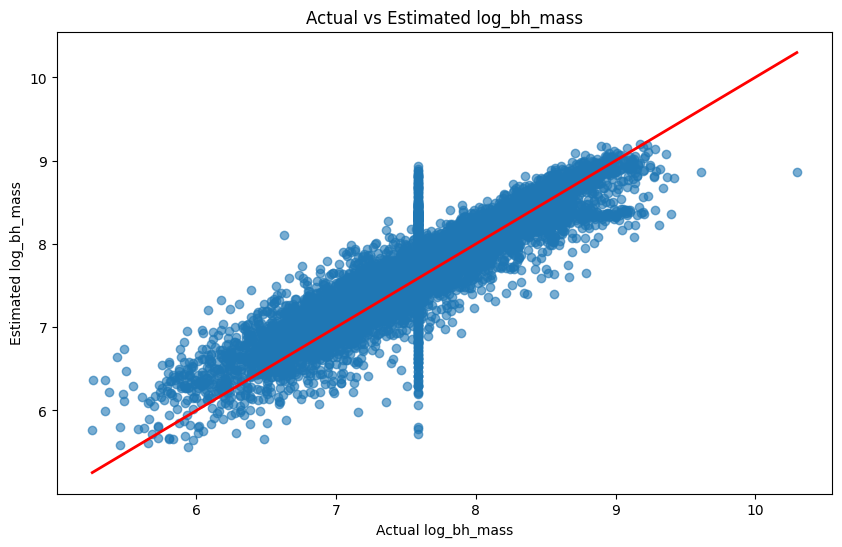

In [ ]:
# Step 7: Plot a graph between actual log_bh_mass and estimated log_bh_mass
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', lw=2)
plt.xlabel('Actual log_bh_mass')
plt.ylabel('Estimated log_bh_mass')
plt.title('Actual vs Estimated log_bh_mass')
plt.show()